Student Test Scores challenge - Predicting scores on students
---

In [205]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [206]:
def final_normalize(df):
    df.columns = [c.replace(' ', '_').strip().lower() for c in df.columns]
    df = df.loc[:, ~df.columns.duplicated()]
    return df

trn_df = pd.read_csv("KaggleData/playground-series-s6e1/train.csv")
test_df = pd.read_csv("KaggleData/playground-series-s6e1/test.csv")
orig_df = pd.read_csv("KaggleData/playground-series-s6e1/StudentPerformanceFactors.csv")

trn_df = final_normalize(trn_df)
test_df = final_normalize(test_df)
orig_df = final_normalize(orig_df)

orig_df.columns = [c.lower() for c in orig_df.columns]

mapping = {
    'hours_studied': 'study_hours',
    'attendance': 'class_attendance',
}
orig_df = orig_df.rename(columns=mapping)

cat_cols = ['gender', 'internet_access']
for col in cat_cols:
    for df in [trn_df, test_df, orig_df]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower()

ordinal_maps = {
    "sleep_quality": {"poor": 0, "average": 1, "good": 2},
    "facility_rating": {"low": 0, "medium": 1, "high": 2},
    "exam_difficulty": {"easy": 0, "moderate": 1, "hard": 2},
    "internet_access": {"no": 0, "yes": 1}
}

for df in [trn_df, test_df, orig_df]:
    for col, mapping in ordinal_maps.items():
        if col in df.columns:
            new_col = f"{col.split('_')[0]}_num" 
            df[new_col] = df[col].map(mapping)

trn_df['is_original'] = 0
orig_df['is_original'] = 1

common_cols = list(set(trn_df.columns) & set(orig_df.columns))
print(f"名寄せ成功！共通カラム数: {len(common_cols)}")
print(common_cols)

common_cols_final = list(set(trn_df.columns) & set(orig_df.columns))
final_selection = list(set(common_cols + ['is_original']))
train_df = pd.concat([trn_df, orig_df[final_selection]], axis=0, ignore_index=True)

valid_split = 0.15
seed = 42

名寄せ成功！共通カラム数: 8
['class_attendance', 'exam_score', 'internet_access', 'sleep_hours', 'gender', 'internet_num', 'study_hours', 'is_original']


In [207]:
def make_features(df):
        
        lut_sleep = {'good': 5, 'average': 0, 'poor': -5}
        lut_facility = {'high': 4, 'medium': 0, 'low': -4}
        lut_method = {
            'coaching': 10, 'mixed': 5, 'group study': 2, 
            'online videos': 1, 'self-study': 0
        }

        # # 各カテゴリを数値化（念のため fillna でエラー回避）
        # s_quality = df['sleep_quality'].map(lut_sleep).fillna(0)
        # f_rating = df['facility_rating'].map(lut_facility).fillna(0)
        # s_method = df['study_method'].map(lut_method).fillna(0)

        # # 投稿者の計算式を再現
        # df['manual_formula'] = (
        #     6.0 * df['study_hours'] + 
        #     0.35 * df['class_attendance'] + 
        #     1.5 * df['sleep_hours'] + 
        #     s_quality + s_method + f_rating
        # )

        df['manual_formula'] = (
        5.9051154511950499 * df['study_hours'] +
        0.34540967058057986 * df['class_attendance'] +
        1.423461171860262 * df['sleep_hours'] + 4.7819
    )
        
        df['high_study'] = (df['study_hours'] >= 7).astype(int)
        df['study_att'] = df['study_hours'] * df['class_attendance']
        
        df['study_sleep_power'] = df['study_hours'] * df['sleep_num']
        df['mental_margin']     = df['sleep_hours'] - df['exam_num']
        df['active_hours']      = 24 - df['sleep_hours']
        df['free_time']         = df['active_hours'] - df['study_hours']
        df['study_ratio']       = df['study_hours'] / df['active_hours']
        df['sleep_interaction'] = df['sleep_hours'] * df['sleep_num']
        df["fatigue"]           = (df["study_hours"] + df["class_attendance"]) / df["sleep_hours"]
        df["focus"]             = df["study_hours"] / (df["internet_num"] + 1)
        df["effort_index"]      = df["study_hours"] * df["class_attendance"]
        df["rest_efficiency"]   = df["sleep_num"] / (df["study_hours"] + 1)
        df["env_advantage"]     = df["facility_num"] * df["internet_num"]
        df['super_effort'] = df['study_hours'] * (df['class_attendance'] ** 2)

        df['study_hours_sq'] = df['study_hours'] ** 2
        df['log_study_hours'] = np.log1p(df['study_hours']) 
        df['class_attendance_sq'] = df['class_attendance'] ** 2
        df['log_class_attendance'] = np.log1p(df['class_attendance'])

        df['study_hours_cubed'] = df['study_hours'] ** 3
        df['sqrt_study_hours'] = np.sqrt(df['study_hours'])
        df['sqrt_class_attendance'] = np.sqrt(df['class_attendance'])

        if 'course' in df.columns:
            df['course_study_mean'] = df.groupby('course')['study_hours'].transform('mean')
            df['study_vs_course_avg'] = df['study_hours'] - df['course_study_mean']

        return df
    
train_df = make_features(train_df)
test_df = make_features(test_df)

kf = KFold(n_splits=5, shuffle=True, random_state=seed)
overall_mean = train_df['exam_score'].mean()

for col in ["course", "study_method"]:
    new_col = f'{col}_te'
    
    target_mean = train_df.groupby(col)['exam_score'].mean()
    test_df[new_col] = test_df[col].map(target_mean).fillna(overall_mean)
    
    train_df[new_col] = 0
    for train_idx, val_idx in kf.split(train_df):
        mean_val = train_df.iloc[train_idx].groupby(col)['exam_score'].mean()
        train_df.loc[val_idx, new_col] = train_df.loc[val_idx, col].map(mean_val)
    
    train_df[new_col] = train_df[new_col].fillna(overall_mean)

train_df['env_synergy'] = train_df['course_te'] * train_df['facility_num']
test_df['env_synergy'] = test_df['course_te'] * test_df['facility_num']

In [208]:
ridge_features = [
    'manual_formula', 
    'study_hours', 'class_attendance', 
    'study_hours_sq', 'class_attendance_sq',
    'course_te', 'study_method_te',  # ← これらを追加！
    'facility_num', 'sleep_num'      # ← 数値化したこれらも追加
]

numerical_cols = [
    "feature_lr_pred",
    "manual_formula",
    "high_study",
    "study_att",
    'study_hours_sq',
    'log_study_hours',
    'class_attendance_sq',
    'log_class_attendance',
    "sleep_interaction",
    "focus",
    "free_time",
    "course_te",
    "class_attendance",
    "study_sleep_power", 
    "study_method_te", 
    "facility_num", 
    "env_synergy", 
    "mental_margin",
    "fatigue",
    "rest_efficiency",
    "env_advantage",
    "super_effort",
    "sleep_hours", 
    "study_hours"
    ]

all_num_cols = list(set(numerical_cols + ridge_features))

for col in all_num_cols:
    if col in train_df.columns:
        fill_val = train_df[col].mean()
        train_df[col] = train_df[col].fillna(fill_val)
        test_df[col] = test_df[col].fillna(fill_val)

X_full = train_df[ridge_features]
y_full = train_df['exam_score']
X_test_ridge = test_df[ridge_features]

ridge = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])

train_df['feature_lr_pred'] = cross_val_predict(
    ridge, X_full, y_full, cv=5, method='predict'
)

ridge.fit(X_full, y_full)
test_df['feature_lr_pred'] = ridge.predict(X_test_ridge)

for col in numerical_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mean())
    test_df[col] = test_df[col].fillna(train_df[col].mean())

nominal_cols = ["gender", "internet_access"]
ordinal_cols = ["sleep_quality", "facility_rating", "exam_difficulty"]

drop_cols = ["id", "age", "exam_num", "internet_num", "study_method", "course", "study_ratio", "study_vs_course_avg", "effort_index"]

final_drop_cols = ["id", "exam_score"] + [c for c in drop_cols if c in train_df.columns]

X = train_df.drop(final_drop_cols, axis=1)
y = train_df["exam_score"]
X_test = test_df.drop([c for c in drop_cols if c in test_df.columns] + ["id"], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=valid_split, random_state=seed,
)

In [209]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), numerical_cols),
        ("nom", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), nominal_cols)
    ],
    remainder="drop",
)

X_train_pre = preprocessor.fit_transform(X_train)
X_valid_pre = preprocessor.transform(X_valid)

In [210]:
model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=seed,
    early_stopping_rounds=100,
    n_jobs=-1,
    verbosity=0,
)

model.fit(
    X_train_pre, y_train,
    eval_set=[(X_valid_pre, y_valid)],
    verbose=200
    )
preds = model.predict(X_valid_pre)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print(rmse)

[0]	validation_0-rmse:18.06909
[200]	validation_0-rmse:8.77324
[400]	validation_0-rmse:8.74401
[600]	validation_0-rmse:8.72664
[800]	validation_0-rmse:8.71495
[1000]	validation_0-rmse:8.70775
[1200]	validation_0-rmse:8.70252
[1400]	validation_0-rmse:8.69873
[1600]	validation_0-rmse:8.69540
[1800]	validation_0-rmse:8.69250
[2000]	validation_0-rmse:8.69066
[2200]	validation_0-rmse:8.68965
[2357]	validation_0-rmse:8.68965
8.689305577514476


In [211]:
# カテゴリ変数のリストを指定（元のカラム名）
cat_features = ["gender", "internet_access", "sleep_quality", "facility_rating", "exam_difficulty"]

# 念のため、カテゴリ変数を 'category' 型、あるいは 'str' 型にしておく
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_valid[col] = X_valid[col].astype(str)
    test_df[col] = test_df[col].astype(str)

cb_model = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.01,
    depth=6,
    loss_function='RMSE',
    random_seed=seed,
    verbose=200,
    early_stopping_rounds=100
)

cb_model.fit(
    X_train, y_train,
    cat_features=cat_features, # ここが最重要！
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

cb_preds = cb_model.predict(X_valid)
cb_rmse = np.sqrt(mean_squared_error(y_valid, cb_preds))

print(f"CatBoost RMSE: {cb_rmse}")

0:	learn: 18.6973463	test: 18.6528333	best: 18.6528333 (0)	total: 74.5ms	remaining: 6m 12s
200:	learn: 9.2574357	test: 9.2285036	best: 9.2285036 (200)	total: 14s	remaining: 5m 33s
400:	learn: 8.8701351	test: 8.8559593	best: 8.8559593 (400)	total: 27.9s	remaining: 5m 20s
600:	learn: 8.8367811	test: 8.8259027	best: 8.8259027 (600)	total: 42.8s	remaining: 5m 12s
800:	learn: 8.8228458	test: 8.8133363	best: 8.8133363 (800)	total: 57.7s	remaining: 5m 2s
1000:	learn: 8.8133103	test: 8.8048689	best: 8.8048689 (1000)	total: 1m 12s	remaining: 4m 49s
1200:	learn: 8.8051535	test: 8.7977936	best: 8.7977936 (1200)	total: 1m 27s	remaining: 4m 37s
1400:	learn: 8.7969738	test: 8.7907073	best: 8.7907073 (1400)	total: 1m 44s	remaining: 4m 28s
1600:	learn: 8.7890082	test: 8.7841063	best: 8.7841063 (1600)	total: 2m	remaining: 4m 15s
1800:	learn: 8.7819719	test: 8.7783610	best: 8.7783610 (1800)	total: 2m 17s	remaining: 4m 3s
2000:	learn: 8.7757234	test: 8.7735051	best: 8.7735051 (2000)	total: 2m 33s	remaini

In [212]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=seed,
    importance_type='gain',
    early_stopping_rounds=100
)

lgb_model.fit(
    X_train_pre, y_train,
    eval_set=[(X_valid_pre, y_valid)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=200)]
)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4232
[LightGBM] [Info] Number of data points in the train set: 541115, number of used features: 27
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 62.544207
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 76.7101
[400]	valid_0's l2: 76.3315
[600]	valid_0's l2: 76.0441
[800]	valid_0's l2: 75.9113
[1000]	valid_0's l2: 75.8244
[1200]	valid_0's l2: 75.7274
[1400]	valid_0's l2: 75.6

LGBMRegressor(early_stopping_rounds=100, importance_type='gain',
              learning_rate=0.05, n_estimators=3000, random_state=42)

In [213]:
lgb_preds = lgb_model.predict(X_valid_pre)

final_ensemble_preds = (preds * 0.4) + (cb_preds * 0.4) + (lgb_preds * 0.2)

ensemble_rmse = np.sqrt(mean_squared_error(y_valid, final_ensemble_preds))
print(f"三本の矢アンサンブル RMSE: {ensemble_rmse}")

三本の矢アンサンブル RMSE: 8.691676723416181


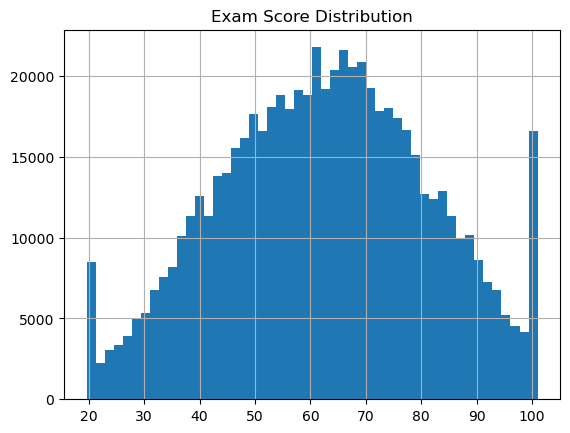

exam_score               1.000000
feature_lr_pred          0.773226
study_vs_course_avg      0.762159
log_study_hours          0.715846
manual_formula           0.705243
sqrt_study_hours         0.704283
effort_index             0.655961
study_att                0.655961
study_ratio              0.640735
study_hours              0.629403
super_effort             0.627649
focus                    0.577468
study_sleep_power        0.559375
high_study               0.440659
sqrt_class_attendance    0.361942
class_attendance         0.361551
log_class_attendance     0.361205
class_attendance_sq      0.357723
study_hours_sq           0.297433
sleep_interaction        0.264402
sleep_num                0.236766
study_method_te          0.223681
env_synergy              0.188174
facility_num             0.188057
fatigue                  0.178064
env_advantage            0.169468
sleep_hours              0.166605
mental_margin            0.153348
study_hours_cubed        0.102463
is_original   

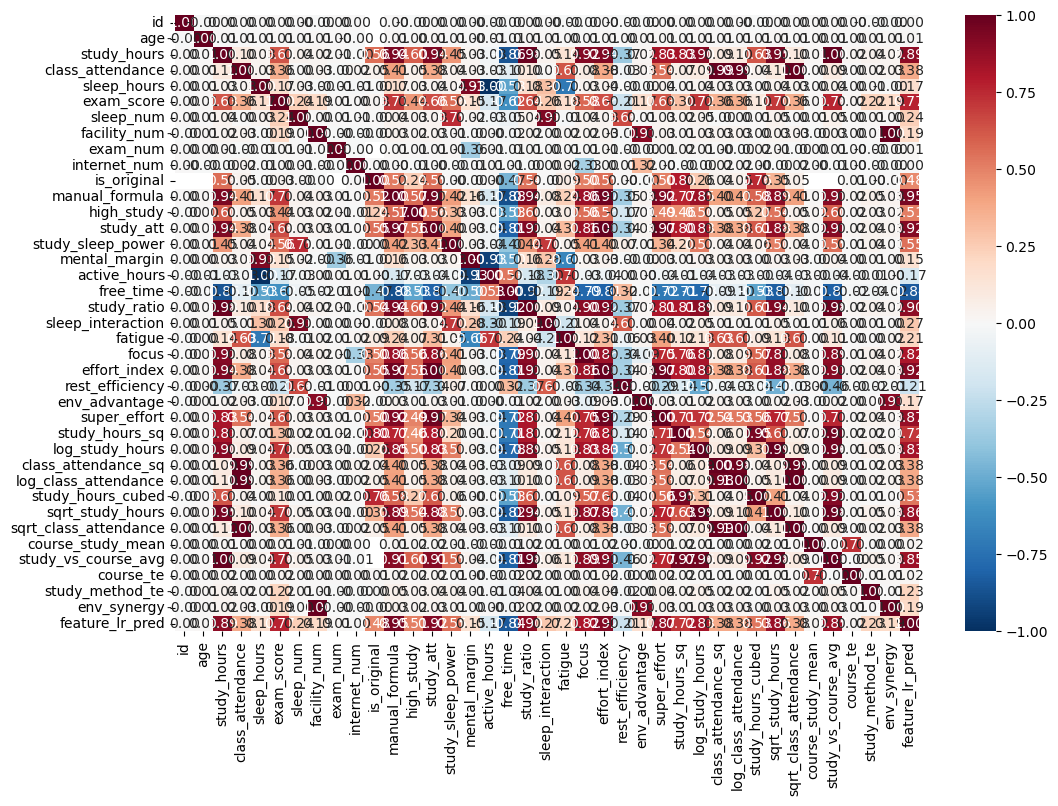

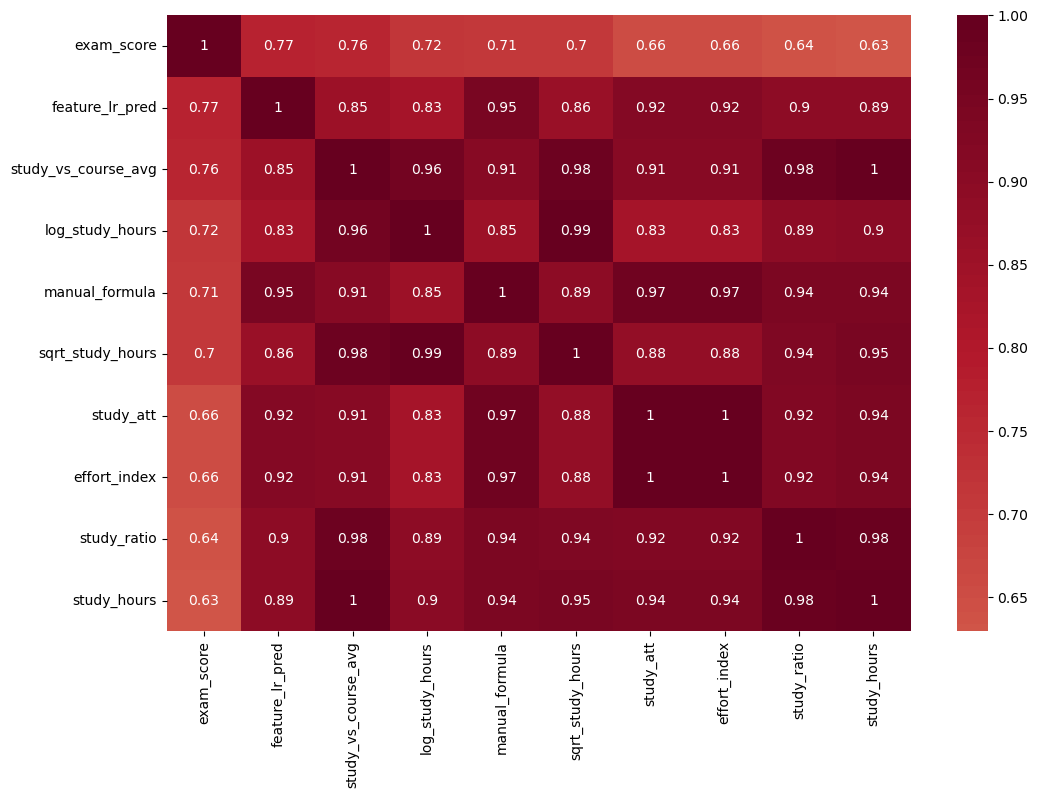

,gender,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,sleep_num,facility_num,...,class_attendance_sq,log_class_attendance,study_hours_cubed,sqrt_study_hours,sqrt_class_attendance,course_study_mean,course_te,study_method_te,env_synergy,feature_lr_pred
613957,female,0.08,97.0,yes,5.0,poor,high,moderate,0.0,2.0,...,9409.00,4.584967,0.000512,0.282843,9.848858,4.018125,62.547331,69.266409,125.094662,49.522791
526766,other,1.01,72.9,no,9.3,average,medium,easy,1.0,1.0,...,5314.41,4.302713,1.030301,1.004988,8.538150,4.025850,62.270191,65.098599,62.270191,50.804665
236686,male,2.02,80.0,yes,8.2,average,high,moderate,1.0,2.0,...,6400.00,4.394449,8.242408,1.421267,8.944272,4.003358,62.504137,65.098599,125.008274,61.853953
629254,other,6.10,54.5,yes,6.3,poor,high,hard,0.0,2.0,...,2970.25,4.016383,226.981000,2.469818,7.382412,4.002332,62.513488,57.660880,125.026976,63.448643
573761,male,4.94,63.8,yes,7.9,poor,high,easy,0.0,2.0,...,4070.44,4.171306,120.553784,2.222611,7.987490,4.003358,62.504137,57.660880,125.008274,61.968560


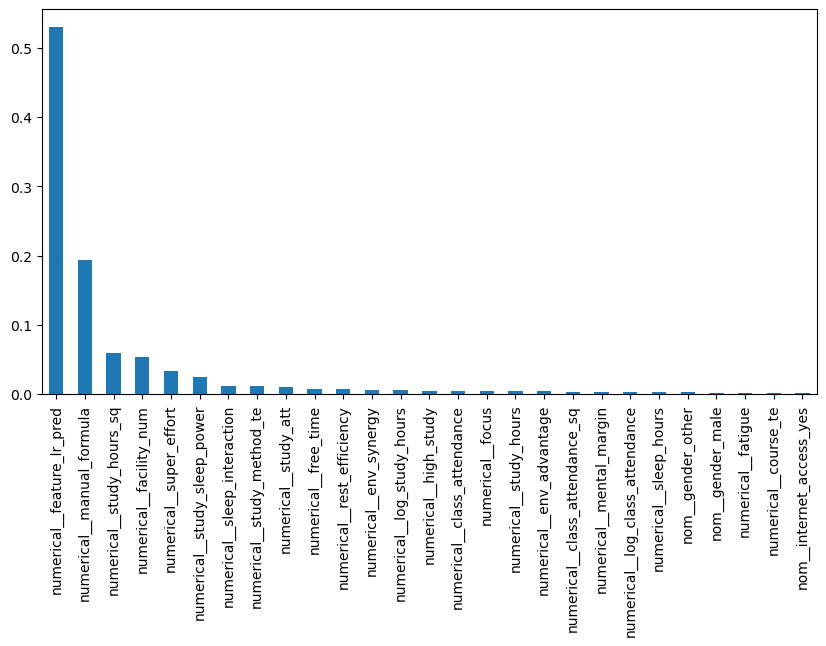

In [214]:
train_df['exam_score'].hist(bins=50)
plt.title("Exam Score Distribution")
plt.show()

X_train.head()

correlations = train_df.select_dtypes(include=[np.number]).corr()['exam_score'].sort_values(ascending=False)
print(correlations)

plt.figure(figsize=(12, 8))
sns.heatmap(train_df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='RdBu_r', fmt='.2f')
plt.show()

top_corr_cols = train_df.corr(numeric_only=True)['exam_score'].abs().sort_values(ascending=False).head(10).index
top_corr_matrix = train_df[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

importances = pd.Series(model.feature_importances_, index=preprocessor.get_feature_names_out())
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))

diff = np.abs(y_valid - final_ensemble_preds)
X_valid.loc[diff.sort_values(ascending=False).index].head(5)

In [215]:
test_df.head(n=2)

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,...,log_class_attendance,study_hours_cubed,sqrt_study_hours,sqrt_class_attendance,course_study_mean,study_vs_course_avg,course_te,study_method_te,env_synergy,feature_lr_pred
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,...,4.192680,321.419125,2.617250,8.074652,3.923891,2.926109,61.886931,60.531838,123.773863,70.109056
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,...,3.828641,288.804781,2.570992,6.708204,3.958814,2.651186,62.404354,69.266665,0.000000,67.937111


In [216]:
X_test_pre = preprocessor.transform(test_df)

X_test['is_original'] = 0
X_test_for_cb = X_test[X_train.columns]

xgb_test_preds = model.predict(X_test_pre)
cb_test_preds = cb_model.predict(X_test_for_cb)
lgb_test_preds = lgb_model.predict(X_test_pre)

final_ensemble_preds = (xgb_test_preds * 0.6) + (cb_test_preds * 0.2) + (lgb_test_preds * 0.2)

sub_df = pd.DataFrame({"id": test_df.id, "exam_score": final_ensemble_preds})
sub_df.to_csv("submission.csv", index=False)